# All the imports

In [1]:
import glob, os
import pandas as pd
import keras
import numpy as np
np.random.seed(1337)  # for reproducibility
########################
from tqdm import tqdm
from random import shuffle as shuffle_array
from sklearn.model_selection import StratifiedKFold
########################
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,  Convolution1D,Convolution2D, MaxPooling2D , AveragePooling2D
from keras.utils import np_utils
from keras.layers.core import Reshape
########################
# This is a comment. 123
########################
import tensorflow as tf
from keras.backend import tensorflow_backend as KTF
KTF.set_session(tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=.80), 
                                                 device_count={'CPU':4, 'GPU':2})))

Using TensorFlow backend.


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline 

# DeepNet-CNN part:

In [3]:
df_data=pd.read_csv('data_padova_50raw.csv')
print(df_data.shape)

(3309200, 9)


In [4]:
df_data.head(10)

,a_x,a_y,a_z,a_mag,g_x,g_y,g_z,g_mag,user_id
0,0.009508,7.057844,2.007554,7.337815,-2.589224,0.298963,0.692806,2.696931,1
1,0.113291,6.768838,2.079149,7.081869,-2.482977,0.233107,0.771536,2.610513,1
2,0.221598,6.563997,2.087110,6.891386,-2.360598,0.167543,0.857614,2.517141,1
3,0.313133,6.436601,2.040757,6.759628,-2.220876,0.114398,0.947024,2.417071,1
4,0.403327,6.367139,1.971043,6.677435,-2.061907,0.075674,1.036515,2.309015,1
5,0.523669,6.360655,1.914970,6.663278,-1.882976,0.041914,1.122601,2.192622,1
6,0.685100,6.437406,1.898472,6.746389,-1.687617,0.004463,1.199868,2.070690,1
7,0.870936,6.606211,1.922702,6.935224,-1.483801,-0.030889,1.262444,1.948431,1
8,1.059214,6.853094,1.962107,7.206712,-1.280098,-0.045461,1.308177,1.830859,1
9,1.232468,7.150560,1.987650,7.523314,-1.082981,-0.020679,1.339630,1.722755,1


In [5]:
df_data.columns

Index([u'a_x', u'a_y', u'a_z', u'a_mag', u'g_x', u'g_y', u'g_z', u'g_mag',
       u'user_id'],
      dtype='object')

In [6]:
df_g=df_data.ix[:,[ u'g_x', u'g_y', u'g_z', u'g_mag',u'user_id']]
df_g.head(4)

,g_x,g_y,g_z,g_mag,user_id
0,-2.589224,0.298963,0.692806,2.696931,1
1,-2.482977,0.233107,0.771536,2.610513,1
2,-2.360598,0.167543,0.857614,2.517141,1
3,-2.220876,0.114398,0.947024,2.417071,1


In [7]:
bad_users=pd.unique(df_g.ix[(df_g.ix[:,'g_x'].isnull()),'user_id'])
good_users=set(np.arange(1,51)).difference(set(bad_users))

df_cleaned=df_data.ix[df_data.user_id.isin(good_users),:]
df_cleaned.shape
len(good_users)

37

In [8]:
df_data=df_cleaned.copy()
N_samples=df_data.shape[0]/200

In [9]:
N_samples

11452

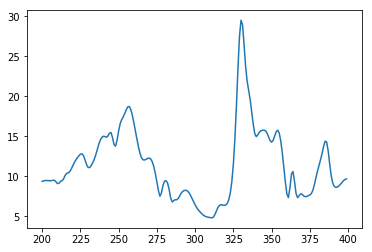

In [10]:
plt.plot(df_data.a_mag[200:400])

In [11]:
col_sensors=[u'a_x', u'a_y', u'a_z', u'a_mag', u'g_x', u'g_y', u'g_z', u'g_mag']
X_train_test=df_data.ix[:,col_sensors].as_matrix().T.reshape(N_samples,8,200,1)
y_train_test_vec=df_data.ix[:,'user_id'].values[0::200]
print(X_train_test.shape)

(11452, 8, 200, 1)


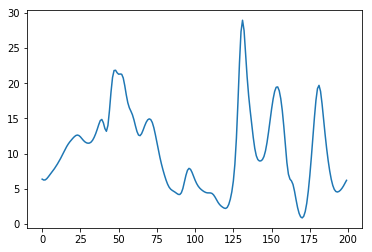

In [12]:
plt.plot(X_train_test[1,3,:,0])

In [13]:
(np.bincount(y_train_test_vec)>100).sum()

37

In [14]:
# from sklearn.model_selection import StratifiedKFold
# For a 80-20 split
skf = StratifiedKFold(n_splits=5,shuffle=True)
ind_split=skf.split(np.zeros(N_samples), y_train_test_vec)
train_indices=ind_split.next()[0]
test_indices=ind_split.next()[1]
shuffle_array(train_indices)
shuffle_array(test_indices)
###############################
y_train=y_train_test_vec[train_indices]
y_test=y_train_test_vec[test_indices]

In [15]:
X_train=X_train_test[train_indices,:,:,:]
X_test=X_train_test[test_indices,:,:,:]

In [16]:
nb_classes=50
# convert class vectors to binary class matrices
#Note that we need to subtract 1 from the user_label to get class label
# that begin at 0
Y_train = np_utils.to_categorical(y_train-1, nb_classes)
Y_test = np_utils.to_categorical(y_test-1, nb_classes)

In [17]:
np.save('X_train_idnet.npy',X_train)
np.save('X_test_idnet.npy',X_test)
np.save('Y_train_idnet.npy',Y_train)
np.save('Y_test_idnet.npy',Y_test)

In [18]:
print(X_train.shape)
print(X_test.shape)

(9149, 8, 200, 1)
(2297, 8, 200, 1)


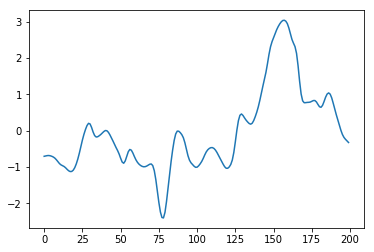

In [19]:
plt.plot(X_test[10,3,:,0])

<img src="IDNet.png">

In [20]:
def IDNet_cnn_keras(weights_path=None, img_rows=8, img_cols=200):
    nb_classes = 50
    # size of pooling area for max pooling
    nb_pool = 3
    ###############################################################
    ###############################################################
    model = Sequential()
    model.add(Convolution2D(20,2,10,dim_ordering='tf', border_mode='same',
                            input_shape=(img_rows, img_cols,1)))
    model.add(Activation('relu'))
    print(model.output_shape)
    model.add(Convolution2D(40, 4, 10,border_mode='same',dim_ordering='tf'))
    model.add(Activation('tanh'))
    print(model.output_shape)
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    print(model.output_shape)
    model.add(Flatten())
    model.add(Dense(40))
    print(model.output_shape)
    model.add(Activation('tanh'))
#     model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    return model
model = IDNet_cnn_keras()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=128,validation_split=0.125, nb_epoch=20,verbose=1)
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

(None, 8, 200, 20)
(None, 8, 200, 40)
(None, 2, 66, 40)
(None, 40)
Train on 8005 samples, validate on 1144 samples
Epoch 1/20
8005/8005 [==============================] - 2s - loss: 2.5803 - acc: 0.3549 - val_loss: 1.9333 - val_acc: 0.5411
Epoch 2/20
8005/8005 [==============================] - 1s - loss: 1.6397 - acc: 0.6091 - val_loss: 1.4227 - val_acc: 0.6705
Epoch 3/20
8005/8005 [==============================] - 1s - loss: 1.2402 - acc: 0.7182 - val_loss: 1.1582 - val_acc: 0.7308
Epoch 4/20
8005/8005 [==============================] - 1s - loss: 0.9797 - acc: 0.7921 - val_loss: 0.9485 - val_acc: 0.7841
Epoch 5/20
8005/8005 [==============================] - 1s - loss: 0.7790 - acc: 0.8437 - val_loss: 0.8002 - val_acc: 0.8243
Epoch 6/20
8005/8005 [==============================] - 1s - loss: 0.6348 - acc: 0.8723 - val_loss: 0.6859 - val_acc: 0.8593
Epoch 7/20
8005/8005 [==============================] - 1s - loss: 0.5243 - acc: 0.9021 - val_loss: 0.6277 - val_acc: 0.8628
Epoch 8/20

In [21]:
y_pred=model.predict_classes(X_test)
(y_pred==y_test-1).sum()/float(len(y_test))

2208/2297 [===========================>..] - ETA: 0s

0.97083151937309531

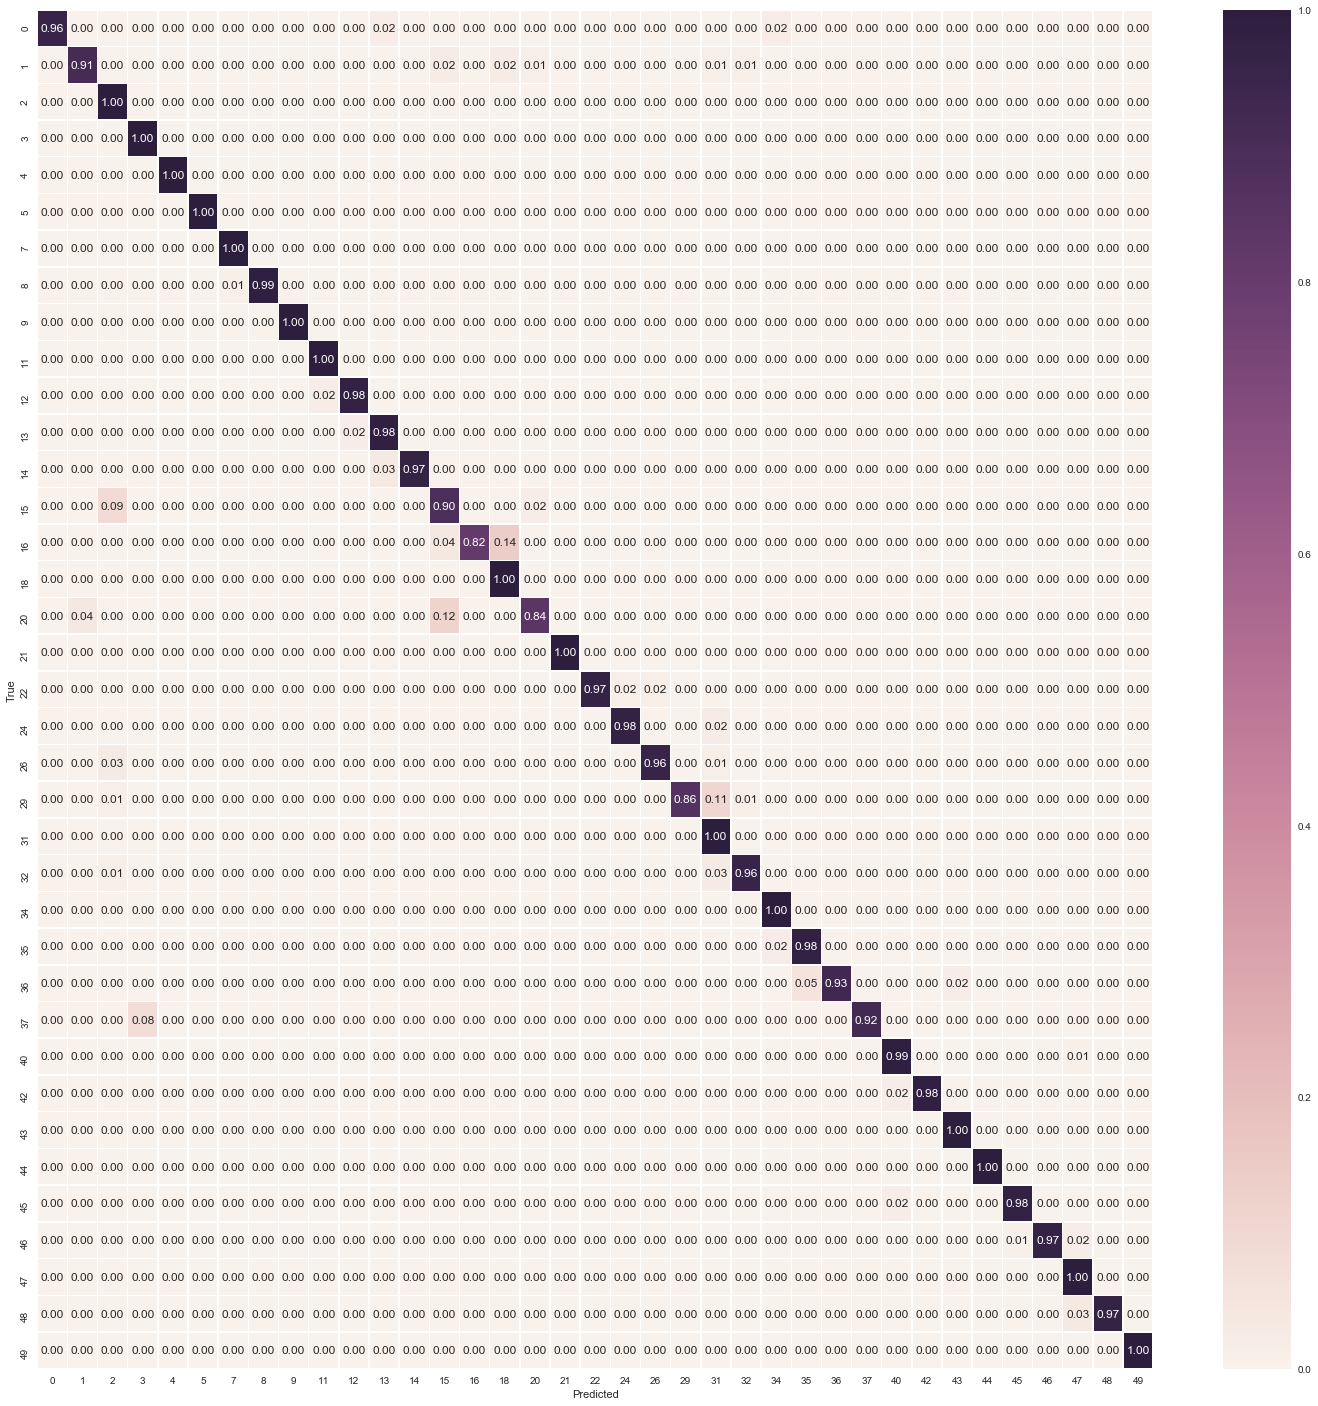

In [22]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(25,25)) 
df_results=pd.DataFrame(data=np.column_stack((y_test-1,y_pred)),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results.True,df_results.Predicted).apply(lambda r: r/r.sum(), axis=1)
sns.heatmap(CT_results, annot=True, fmt=".2f", linewidths=.5,ax=ax)

In [23]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 8, 200, 20)    420         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 8, 200, 20)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 8, 200, 40)    32040       activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 8, 200, 40)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

# Tensorflow inits ..

In [24]:
from keras import backend
from keras.utils import np_utils
#############################################
from cleverhans.utils_tf import model_train, model_eval, batch_eval
from cleverhans.attacks import fgsm
from cleverhans.utils import cnn_model
# Look at the function below
#############################################


In [25]:
# 1: Create TF session and set as Keras backend session
sess = tf.Session()
keras.backend.set_session(sess)
# 2:  Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, 8, 200, 1))
y = tf.placeholder(tf.float32, shape=(None, nb_classes))

# 3: Define TF model graph
# model = cnn_model_custom(img_rows=32, img_cols=32, channels=3)
predictions = model(x)
print("Defined TensorFlow model graph.")

Defined TensorFlow model graph.


# Training ..

In [26]:
from cleverhans.utils_tf2 import model_train as model_train_acc

In [27]:
def evaluate():
    # Evaluate the accuracy of the CIFAR10 model on legitimate test examples
    eval_params = {'batch_size': 128}
    accuracy = model_eval(sess, x, y, predictions, X_test, Y_test,
                          args=eval_params)
#     print('Test accuracy on legitimate test examples: ' + str(accuracy))
    return accuracy

train_params = {'nb_epochs': 15,
    'batch_size': 128,
    'learning_rate': 0.1
}

# from cleverhans.utils_tf import model_train
accuracy_plain=model_train_acc(sess, x, y, predictions, X_train, Y_train,evaluate=evaluate,verbose=True, args=train_params)
accuracy_plain


Epoch 0
	Epoch took 1.34588003159 seconds
Epoch 1
	Epoch took 1.27791309357 seconds
Epoch 2
	Epoch took 1.28005290031 seconds
Epoch 3
	Epoch took 1.27791404724 seconds
Epoch 4
	Epoch took 1.27769112587 seconds
Epoch 5
	Epoch took 1.2743499279 seconds
Epoch 6
	Epoch took 1.28346300125 seconds
Epoch 7
	Epoch took 1.28828811646 seconds
Epoch 8
	Epoch took 1.28429579735 seconds
Epoch 9
	Epoch took 1.2813410759 seconds
Epoch 10
	Epoch took 1.28468394279 seconds
Epoch 11
	Epoch took 1.28443002701 seconds
Epoch 12
	Epoch took 1.28654313087 seconds
Epoch 13
	Epoch took 1.28310799599 seconds
Epoch 14
	Epoch took 1.28889203072 seconds
Completed model training.


[0.54462342037550515,
 0.67914671009397531,
 0.77666521632884133,
 0.79886808639824469,
 0.8528515450010935,
 0.8807139731408411,
 0.90639965000700629,
 0.90378754726429844,
 0.92903787164933072,
 0.93339137733631361,
 0.94558118992802576,
 0.95820635419645461,
 0.94558119205583635,
 0.95515890099662881,
 0.95690030282510075]

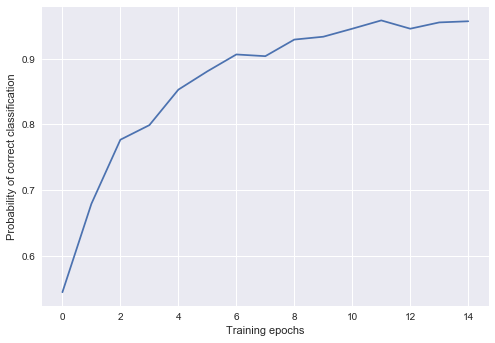

In [28]:
plt.plot(accuracy_plain)
plt.xlabel('Training epochs')
plt.ylabel('Probability of correct classification')

# Craft adversarial examples using Fast Gradient Sign Method (FGSM)

In [29]:
adv_x = fgsm(x, predictions, eps=0.5)
eval_params = {'batch_size': 128}
X_test_adv, = batch_eval(sess, [x], [adv_x], [X_test], args=eval_params)

accuracy = model_eval(sess, x, y, predictions, X_test, Y_test,
                      args=eval_params)
print('Test accuracy on true examples: ' + str(accuracy))

accuracy = model_eval(sess, x, y, predictions, X_test_adv, Y_test,
                      args=eval_params)
print('Test accuracy on adversarial examples: ' + str(accuracy))

cleverhans/attacks.py:439: UserWarning: attacks.fgsm is deprecated and will be removed on 2017-09-27. Instantiate an object from FastGradientMethod.
  warnings.warn("attacks.fgsm is deprecated and will be removed on "


Test accuracy on true examples: 0.956900302825
Test accuracy on adversarial examples: 0.435785806719


In [30]:
X_test_adv.shape

(2297, 8, 200, 1)

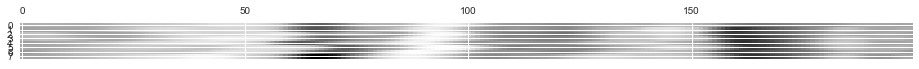

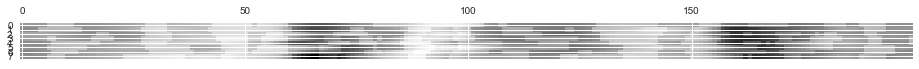

In [31]:
plt.matshow(X_test[2,:,:,0])
plt.matshow(X_test_adv[2,:,:,0])

In [32]:
adv_acc_vec=[]
eps_vec=np.linspace(0,2,11)
for eps_chosen in eps_vec:
    adv_x = fgsm(x, predictions, eps=eps_chosen)
    eval_params = {'batch_size': 128}
    X_test_adv, = batch_eval(sess, [x], [adv_x], [X_test], args=eval_params)

    accuracy = model_eval(sess, x, y, predictions, X_test_adv, Y_test,
                          args=eval_params)
    print('Test accuracy on adversarial examples: ' + str(accuracy))
    adv_acc_vec.append(accuracy)

Test accuracy on adversarial examples: 0.956900302825
Test accuracy on adversarial examples: 0.698302132231
Test accuracy on adversarial examples: 0.503265128273
Test accuracy on adversarial examples: 0.383108400603
Test accuracy on adversarial examples: 0.308663473201
Test accuracy on adversarial examples: 0.249891162256
Test accuracy on adversarial examples: 0.205920766191
Test accuracy on adversarial examples: 0.166303874347
Test accuracy on adversarial examples: 0.136264692909
Test accuracy on adversarial examples: 0.111449716896
Test accuracy on adversarial examples: 0.0988245535777


(0, 2)

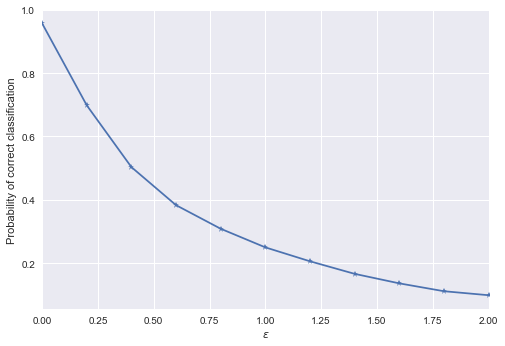

In [33]:
plt.plot(eps_vec,adv_acc_vec,'-*')
plt.ylabel('Probability of correct classification')
plt.xlabel('$\epsilon$')
plt.xlim([0,2])

In [34]:
adv_x = fgsm(x, predictions, eps=2)
eval_params = {'batch_size': 128}
X_test_adv, = batch_eval(sess, [x], [adv_x], [X_test], args=eval_params)

accuracy = model_eval(sess, x, y, predictions, X_test_adv, Y_test,
                      args=eval_params)
print('Test accuracy on adversarial examples: ' + str(accuracy))

Test accuracy on adversarial examples: 0.0988245535777


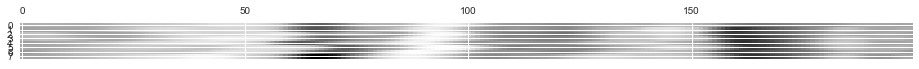

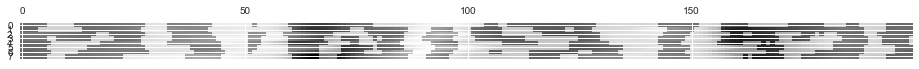

In [35]:
plt.matshow(X_test[2,:,:,0])
plt.matshow(X_test_adv[2,:,:,0])

In [36]:
# Redefine TF model graph
model_2 = model
predictions_2 = model_2(x)
adv_x_2 = fgsm(x, predictions_2, eps=0.3)
predictions_2_adv = model_2(adv_x_2)

def evaluate_2():
    # Evaluate the accuracy of the adversarialy trained CIFAR10 model on
    # legitimate test examples
    eval_params = {'batch_size': 128}
    accuracy = model_eval(sess, x, y, predictions_2, X_test, Y_test,
                          args=eval_params)
    print('Test accuracy on legitimate test examples: ' + str(accuracy))

    # Evaluate the accuracy of the adversarially trained CIFAR10 model on
    # adversarial examples
    accuracy_adv = model_eval(sess, x, y, predictions_2_adv, X_test,
                              Y_test, args=eval_params)
    print('Test accuracy on adversarial examples: ' + str(accuracy_adv))

# # Perform adversarial training
# model_train(sess, x, y, predictions_2, X_train, Y_train,
#             predictions_adv=predictions_2_adv, evaluate=evaluate_2,
#             args=train_params)

# # Evaluate the accuracy of the CIFAR10 model on adversarial examples
# accuracy = model_eval(sess, x, y, predictions_2_adv, X_test, Y_test,
#                       args=eval_params)
# print('Test accuracy on adversarial examples: ' + str(accuracy))

# def evaluate():
#     # Evaluate the accuracy of the CIFAR10 model on legitimate test examples
#     eval_params = {'batch_size': 128}
#     accuracy = model_eval(sess, x, y, predictions, X_test, Y_test,
#                           args=eval_params)
# #     print('Test accuracy on legitimate test examples: ' + str(accuracy))
#     return accuracy

# train_params = {'nb_epochs': 15,
#     'batch_size': 128,
#     'learning_rate': 0.1
# }

# # from cleverhans.utils_tf import model_train
# accuracy=model_train_acc(sess, x, y, predictions, X_train, Y_train,evaluate=evaluate,verbose=True, args=train_params)
# accuracy

In [37]:
# Redefine TF model graph
model_2 = model
predictions_2 = model_2(x)
adv_x_2 = fgsm(x, predictions_2, eps=1)
predictions_2_adv = model_2(adv_x_2)

train_params = {'nb_epochs': 15,
    'batch_size': 128,
    'learning_rate': 0.1
}

# Perform adversarial training
model_train(sess, x, y, predictions_2, X_train, Y_train, verbose=False,
            predictions_adv=predictions_2_adv, evaluate=None,
            args=train_params)


accuracy = model_eval(sess, x, y, predictions_2, X_test, Y_test,args=eval_params)
print('Test accuracy on legitimate test examples: ' + str(accuracy))

accuracy = model_eval(sess, x, y, predictions_2_adv, X_test, Y_test,args=eval_params)
print('Test accuracy on adversarial examples: ' + str(accuracy))



Completed model training.
Test accuracy on legitimate test examples: 0.894645189793
Test accuracy on adversarial examples: 0.629081407733


In [40]:
adv_acc_pre=[]
adv_acc_post=[]
eps_vec=np.linspace(0,2,11)
for eps_chosen in eps_vec:
    model = IDNet_cnn_keras()
    x = tf.placeholder(tf.float32, shape=(None, 8, 200, 1))
    y = tf.placeholder(tf.float32, shape=(None, nb_classes))
    predictions = model(x)
    accuracy_plain=model_train_acc(sess, x, y, predictions, X_train, Y_train,evaluate=evaluate,verbose=False, args=train_params)
    print(accuracy_plain[-1])
    print(str(eps_chosen))
    adv_x = fgsm(x, predictions, eps=eps_chosen)
    eval_params = {'batch_size': 128}
    X_test_adv, = batch_eval(sess, [x], [adv_x], [X_test], args=eval_params)

    accuracy = model_eval(sess, x, y, predictions, X_test_adv, Y_test,
                          args=eval_params)
    print('Test accuracy on adversarial examples (Pre): ' + str(accuracy))
    adv_acc_pre.append(accuracy)
    #########################################
    model_2 = model
    predictions_2 = model_2(x)
    adv_x_2 = fgsm(x, predictions_2, eps=eps_chosen)
    predictions_2_adv = model_2(adv_x_2)

    train_params = {'nb_epochs': 15,
        'batch_size': 128,
        'learning_rate': 0.1
    }

    # Perform adversarial training
    model_train(sess, x, y, predictions_2, X_train, Y_train, verbose=False,
                predictions_adv=predictions_2_adv, evaluate=None,
                args=train_params)

    accuracy = model_eval(sess, x, y, predictions_2_adv, X_test, Y_test,args=eval_params)
    print('Test accuracy on adversarial examples (Post): ' + str(accuracy))
    adv_acc_post.append(accuracy)

(None, 8, 200, 20)
(None, 8, 200, 40)
(None, 2, 66, 40)
(None, 40)
Completed model training.
0.96168915775
0.0
Test accuracy on adversarial examples (Pre): 0.96168915775
Completed model training.
Test accuracy on adversarial examples (Post): 0.969960815527
(None, 8, 200, 20)
(None, 8, 200, 40)
(None, 2, 66, 40)
(None, 40)
Completed model training.
0.97300827075
0.2
Test accuracy on adversarial examples (Pre): 0.698737482688
Completed model training.
Test accuracy on adversarial examples (Post): 0.846321287236
(None, 8, 200, 20)
(None, 8, 200, 40)
(None, 2, 66, 40)
(None, 40)
Completed model training.
0.962124509219
0.4
Test accuracy on adversarial examples (Pre): 0.490639963654
Completed model training.
Test accuracy on adversarial examples (Post): 0.801044839696
(None, 8, 200, 20)
(None, 8, 200, 40)
(None, 2, 66, 40)
(None, 40)
Completed model training.
0.96734871582
0.6
Test accuracy on adversarial examples (Pre): 0.377448845569
Completed model training.
Test accuracy on adversarial 

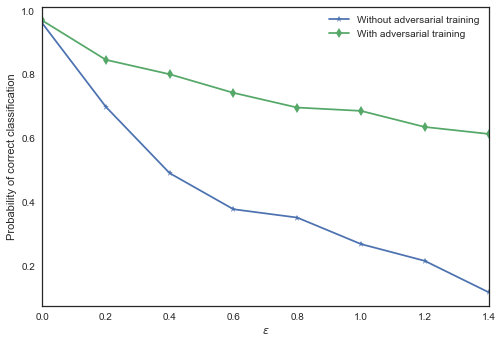

In [45]:
with plt.style.context(('seaborn-white')):
    plt.plot(eps_vec[0:-3],adv_acc_pre[0:-3],'-*',eps_vec[0:-3],adv_acc_post[0:-3],'-d')
    plt.ylabel('Probability of correct classification')
    plt.xlabel('$\epsilon$')
    plt.xlim([0,1.4])
    plt.legend(['Without adversarial training','With adversarial training'])
    plt.savefig('Pr_eps.eps')
    plt.savefig('Pr_eps.pdf')

In [46]:
adv_x = fgsm(x, predictions, eps=0.4)
eval_params = {'batch_size': 128}
X_test_adv, = batch_eval(sess, [x], [adv_x], [X_test], args=eval_params)


Test accuracy on true examples: 0.93295602566
Test accuracy on adversarial examples: 0.726599911632


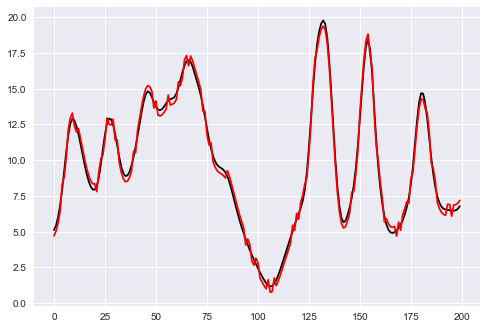

In [73]:
rand_ind=84
plt.plot(X_test[rand_ind,3,:,0],'-k')
plt.plot(X_test_adv[rand_ind,3,:,0],'-r')

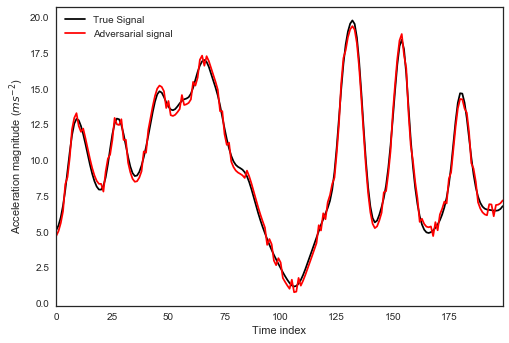

In [76]:
with plt.style.context(('seaborn-white')):
    plt.plot(X_test[rand_ind,3,:,0],'-k')
    plt.plot(X_test_adv[rand_ind,3,:,0],'-r')
    plt.ylabel('Acceleration magnitude ($ms^{-2}$)')
    plt.xlabel('Time index')
    plt.xlim([0,199])
    plt.legend(['True Signal','Adversarial signal'])
    plt.savefig('a_mag_adv.eps')
    plt.savefig('a_mag_adv.pdf')
